<a href="https://colab.research.google.com/github/ugurtegin/MMF_RNN_Reuse/blob/main/GRIN_BPM_SC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beam propagation method - Notebook

This first notebook presents the general concepts and the numerical implementation of beam propagation method (BPM) in free space. 
The propagation of a monochromatic wave in an homogeneous medium is described by the scalar Helmoltz equation (wave equation):

$$
\frac{\partial^2E}{\partial x^2} + \frac{\partial^2E}{\partial y^2} + \frac{\partial^2E}{\partial z^2} + k^2E=0
$$

where $E$ is the scalar field and $k=\omega\sqrt{\varepsilon\mu}$ is the wavenumber in the propagation medium. 

In BPM we assume that the wave is propagating along a specific axis, in the following $z$, and we factorize the field as a product of an enveloppe $A(x,y,z)$ and a fast oscillating term along the propagation direction $\exp(-jkz)$. By plugging $E=A\exp(-jkz)$ in the wave equation we can write in the wave equation we get:

$$
2jk\frac{\partial A}{\partial z} = \frac{\partial^2A}{\partial x^2} + \frac{\partial^2A}{\partial y^2} + \frac{\partial^2A}{\partial z^2}
$$

If we now consider that the dependence of $A$ on $z$ is slow because the fast variation along this axis is taken into account by the fast oscillating term $\exp(-jkz)$ we can neglect the second order derivative along $z$, better knwon as slowly varying envelope (SVE) approximation. We finally get to the BPM equation in free space

$$
\frac{\partial A}{\partial z} = \hat{A}A
$$

where we labelled with $\hat{A}$ the diffraction operator:

$$
\hat{A} = \frac{j}{2k}\left(\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}\right)
$$

In practice it is more convenient to solve this first order partial differential equation in the spatial frequency domain. Indeed if we take the Fourier transform of $A$ with respect to $x$ and $y$, labelled $\tilde{A}$ hereafter, we get:

$$
\frac{\partial \tilde{A}}{\partial z}=-\frac{j}{2k} \left(K_x^2+K_y^2\right)\tilde{A} 
$$

This is a differential equation in $z$ with general solution:

$$
\tilde{A}(x,y,z+\Delta z) = \tilde{A}(x,y,z)\exp(D\Delta z)
$$

with 

$$
D = -\frac{i}{2k} \left(K_x^2+K_y^2\right) 
$$

being the diffraction operator in the frequency domain. 
In summary, the SVE propagation describing diffraction can be solved in the inverse space and then transformed back in the direct space:

$$
A(x,y,z+\Delta z) = \text{IFT}\left\{\text{FT}[A(x,y,z)]\exp(D\Delta z)\right\}
$$

where $FT$ and $IFT$ denote Fourier transform and its inverse operation, respectively.



In the following we will numerically implement the BPM algorithm with numpy library in python. You will find at the beginning of each cell a brief description of the operations that are carried out.


## Load Libraries

Here we simply load the main python libraries we will use. We also mount our Google drive which should contain any file we want to load in the script. Also, we can directly download a file if it is shared on google drive.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import time
from scipy import special


In [2]:
## This will prompt for authorization. This enables to load files stored in your google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
## This will directly download a file which is shared on google drive 
## (may need to add '&confirm=t' at the end of the link)

# !gdown '11CxD_u9rBpV34eoM6WisQyVNPcJk7VUk'  # Newton.mat  # May not work
!gdown 'https://drive.google.com/uc?id=11CxD_u9rBpV34eoM6WisQyVNPcJk7VUk&confirm=t'  # Newton.mat
!gdown 'https://drive.google.com/uc?id=1uLwj_sPxiHqZRMHBt5OoAr_9M_aa5ePS&confirm=t'  # einsteins5x5.mat


Downloading...
From: https://drive.google.com/uc?id=11CxD_u9rBpV34eoM6WisQyVNPcJk7VUk&confirm=t
To: /content/Newton.mat
100% 172k/172k [00:00<00:00, 94.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uLwj_sPxiHqZRMHBt5OoAr_9M_aa5ePS&confirm=t
To: /content/einsteins5x5.mat
100% 5.76M/5.76M [00:00<00:00, 111MB/s]


### Setup the environment and define the computation window

First of all we have to define a simulation domain as we will have to discretize continuous fields on a uniform 3D grid with $N_x\times N_y\times N_z$ pixels. Furthermore for the sake of clarity we use the following convention: the variables with the underscore (e.g. `Lx_`) are expressed in physical units (e.g. meters). When the underscore is removed means that the variables are normalized. 

You should take care here to correctly setup:
- the number of pixels in the three directions(`Nx`, `Ny`, `Nz`)
- the size of your physical domain (`Lx_`,`Ly_`,`Lz_`)
- the refractive index of the propagation medium `n0_`
- the working wavelength `lambda0_`

In [4]:
## Computation domain discretization
Nz       = 100         # Number of steps in the z direction <---### EDIT HERE ###
Nx       = 512         # x-direction size of computational grid
Ny       = Nx          # x-direction size of computational grid. The computation domain is square

## Physical dimension of the computation space. Physical values are denoted with an underscore. The corresponding normalized value are written without underscore.
## We use SI units
Lx_ = 200e-6     # width of the computation window [m]  <---### EDIT HERE ###
Ly_ = Lx_		     # height of the computation window [m] <---### EDIT HERE ###
Lz_ = 100e-6     # propagation distance [m]             <---### EDIT HERE ###

n0_ = 1        # refractive index of background    <---### EDIT HERE ###

lambda0_ = 532e-9      # free space wavelength [m]        <---### EDIT HERE ###
delta_   = 1.0			   # normalization parameter (see documentation on SSF)
V = np.zeros((Ny, Nx))    # Index potential. This correspond to the refractive index difference with respect to background
                          # for a homogeneous medium, V = 0. <---### EDIT HERE ###


## Setup the SSF-BPM variables
Normally, you shouldn't need to edit this section at all. Just few notes on the content of this cell.
First we define some useful physical constants. Then we normalize all the quanities of interest. Finally we create the spatial grid in the direct and inverse space. Specifically we sample the transverse $x,y$ plane with $N_x\times N_y$ points going from $- L_x/2$ to $L_x/2$ and from $- L_y/2$ to $L_y/2$. Also, to implement Fourier transform and its inverse numerically we will use in the following the very common fast fourer transform (FFT) algorithm. When calculating the spectrum of a function with FFT, the algorithm returns an array which concatenates the spectrum for positive frequencies with the spectrum for negative frequencies. This means that the frequency axis is represented as $[0,...f_N,-f_N,...-1]$ with $f_N$ the Nyquist frequency. For this reason we define $k_x$ and $k_y$ axes accordingly as concatenation of two arrays, one $[0,\pi N_{x,y}/L_{x,y})$ and the other $[-\pi N_{x,y}/L_{x,y}, 0)$. Please notice that the line

```python
kx  = dkx * np.concatenate((np.arange(0,Nx/2,1),np.arange(-Nx/2,0,1)))     
```

is equivalent to

```python
kx  = np.fft.ifftshift(dkx  * np.arange(-Nx/2,Nx/2,1))     
```

Check [here](https://numpy.org/doc/stable/reference/generated/numpy.fft.fftshift.html) for further information.

In [5]:
## Physical constants
mu0 = 4.0e-7 * np.pi    # free space magnetic permeability [Vs/Am]
c0  = 2.99792458e+8     # free space light speed [m/s]

epsilon0 = 1.0 / (mu0 * c0**2)         # free space permittivity [As/Vm]
eta0     = np.sqrt(mu0 / epsilon0)    # free space impedance [ohm]

## Derived parameters
k0_     = 2 * np.pi / lambda0_       			# free space wavenumber [m-1]
k_      = n0_ * k0_                     # medium wavenumber [m-1]
lambda_ = lambda0_ / n0_                # medium wavelength [m]

## Normalization coefficients
## The equation can be normalized to a dimensionless form
## spatial normalization factor in the x-y plane
spatial_transverse_scale = 1/(k0_ * np.sqrt(2 * n0_ *  delta_))
## spatial normalization factor in the z direction
spatial_longitudinal_scale = 1/(delta_ * k0_)

scale_ratio = spatial_longitudinal_scale/spatial_transverse_scale  # = sqrt(2*n0_/delta_)

## ************* Normalized parameters *************
Lx = Lx_ / spatial_transverse_scale                # normalized model width
Ly = Ly_ / spatial_transverse_scale                # normalized model height
Lz = Lz_ / spatial_longitudinal_scale              # normalized propagation distance
k  = 2*np.pi * spatial_transverse_scale / lambda_  # normalized light k-vector

## ************ Numeric model parameters ***********
dx_ = Lx_/Nx                                                                # normalized discretization step in x
dx  = Lx/Nx                                                                 # discretization step in x
x_  = dx_ * np.arange(-Nx/2,Nx/2,1)                                         # x dimension vector
x   = dx  * np.arange(-Nx/2,Nx/2,1)                                         # normalized x dimension vector
dkx = 2*np.pi/Lx                                                            # discretization in the spatial spectral domain along the y direction
kx  = dkx * np.concatenate((np.arange(0,Nx/2,1),np.arange(-Nx/2,0,1)))     	# spatial frequencies vector in the x direction (swapped)

## We do the same in the y and z direction
dy_ = Ly_/Ny                                                                # normalized discretization step in x
dy  = Ly/Ny                                                                 # discretization step in x
y_  = dy_ * np.arange(-Ny/2,Ny/2,1)                                         # x dimension vector
y   = dy  * np.arange(-Ny/2,Ny/2,1)                                         # normalized x dimension vector
dky = 2*np.pi/Ly                                                            # discretization in the spatial spectral domain along the y direction
ky  = dky * np.concatenate((np.arange(0,Ny/2,1),np.arange(-Ny/2,0,1)))     	# spatial frequencies vector in the x direction (swapped)

dz  = Lz/Nz
dz_ = Lz_/Nz
z   = dz * np.arange(1,Nz+1,1) 
z_  = dz_* np.arange(1,Nz+1,1) 

## Here we create the spatial computation grid (physical and normalized)
[X_, Y_]    = np.meshgrid(x_, y_)
[Xz_, Z_]   = np.meshgrid(x_, z_)
[X, Y]      = np.meshgrid(x, y)
[Xz, Z]     = np.meshgrid(x, z)

## The same for the spatial frequencies domain
[Kx, Ky]    = np.meshgrid(kx, ky)

K2 = np.multiply(Kx,Kx) + np.multiply(Ky,Ky) # Here we define some variable so that we don't need to compute them again and again


### Define boundary conditions

In the cell below we set can two conditions. The first one is choosing between paraxial and non paraxial approximation through the variable `nonparaxial`. When we can assume that the plane wave propagates along $z$ axis the paraxial approximation gives good predictions. If the angle $\theta$ formed between the $k$ vector and the $z$ axis is large enough such that we cannot approximate $\sin(\theta)\approx\theta$ we have to take this correction into account and substitute the infinitesimal propagation distance $dz$ with $dz/\cos(\theta)$. In practice this will result in a different diffraction kernel with respect to the one described in the introduction:

$$
D = -\frac{i}{k+\sqrt{k^2-K_x^2-K_y^2}} \left(K_x^2+K_y^2\right)
$$

The second condition we can set is the boundary condition through the variable `absorbing_boundary`. When the field gets to one side boundary it will appear from the opposite side due to periodic boundary condition from FFT. To prevent that, we can either make the computation window bigger if we have room in terms of time and computation power OR we can apply absorbing boundaries by lowering the intensity towords boundaries. However we have to do it smoothly, otherwise numerical reflections will appear and results would be messed-up. To do that, we will multiply the field at every step with a rectangular super gaussian function that is mostly 1 but goes to 0 towards boundaries in a smooth manner. 

In [6]:
## Variable that allows to switch between the paraxial (nonparaxial = 0) and nonparaxial (nonparaxial = 1) algorithm.
nonparaxial  = 0   # <---### EDIT HERE ###

## IF YOU WANT TO HAVE absorbing boundaries, set absorbing_boundary=1 below, 
## otherwise set it to 0.
absorbing_boundary = 1
super_gaussian=np.exp(-((X_ / (0.9*Lx_/(2*np.sqrt(np.log(2)))) )**20 + (Y_ / (0.9*Ly_/(2*np.sqrt(np.log(2)))) )**20))


## Definition of the input field
Here, we define the complex input field either by generating here or loading from another file. As a template we report here below few different options:

- A gaussian beam, that can be defined through its full width half maximum
- A tilted plane wave of the type $\exp[jk(\sin\theta_xx+\sin\theta_yy)]$ 
- A circular or rectangular aperture
- An arbitrary wavefront loaded from an external file through `scipy.io` library (please pay attention to provide the correct path of the external file in your Google Drive)

In [7]:
A = 1       		 # field amplitude of the input beam

## Generate input field. Below, an example with Gaussian beam as the input
beam_fwhm_ = 80e-6           # <---### EDIT HERE ###
beam_scale_ = beam_fwhm_ / (2*np.sqrt(np.log(2)))
gaussian_beam = np.exp(-(X_/beam_scale_)**2 - (Y_/beam_scale_)**2)

## Generate angle of the input beam. We do it by multiplying the input field with a blazed grating
theta_x = 0       # [degree] angle in x direction <---### EDIT HERE ###
theta_y = 0       # [degree] angle in y direction <---### EDIT HERE ###
theta_x = theta_x*np.pi/180
theta_y = theta_y*np.pi/180
blazed_grating = np.exp(1j*2*np.pi/lambda_*(np.sin(theta_x)*X_+np.sin(theta_y)*Y_))

## Circular aperture
circular_aperture = np.zeros((Nx,Ny))
aperture_diameter  = 100e-6                # [m] <---### EDIT HERE ###
circular_aperture[X_**2+Y_**2 <= (aperture_diameter/2)**2]=1

## rectangular aperture
rectangular_aperture = np.zeros((Nx,Ny))
width_x  = 200e-6         # [m] <---### EDIT HERE ###
width_y  = 200e-6         # [m] <---### EDIT HERE ###
x_shift = 0e-6            # [m]<---### EDIT HERE ###
y_shift = 0e-6            # [m]<---### EDIT HERE ###
rectangular_aperture[np.logical_and(np.abs(X_-x_shift)<=width_x/2,  np.abs(Y_-y_shift)<=width_y/2)]=1 

## load data from Google drive
# filename = '/content/drive/MyDrive/BPM lecture/Newton.mat' # As an example, Newton.mat file is stored in a folder called "BPM lecture" in my drive
filename = '/content/Newton.mat'
mat_contents = sio.loadmat(filename)
image_newton = mat_contents['newton']
print("data loaded...")
print(f"shape = {image_newton.shape}, dtype = {image_newton.dtype}, value range = [{image_newton.min()}, {image_newton.max()}]")

## u is our input field
u = gaussian_beam * np.exp(1j*image_newton)
u = image_newton * np.exp(1j*np.zeros((Nx,Ny)))  # <---### EDIT HERE ###

## We declare this variable to monitor propagation (in the x-z plane)
fields = np.array(np.zeros((Nx,Ny,Nz)), dtype=complex)

## Assign the first step input value to be your input field
u0 = u


data loaded...
shape = (512, 512), dtype = float64, value range = [0.0, 1.0166783026620454]


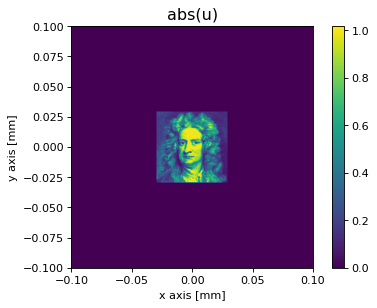

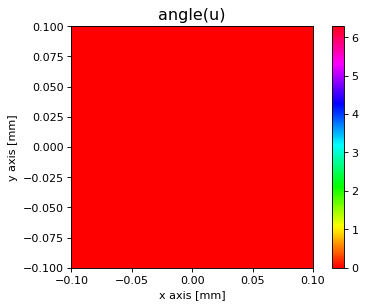

In [8]:
fig_dpi = 80
plt.figure(dpi = fig_dpi)
plt.imshow(np.abs(u), extent=[-Lx_/2*1e3,Lx_/2*1e3,-Ly_/2*1e3,Ly_/2*1e3])
plt.colorbar()
plt.xlabel('x axis [mm]')
plt.ylabel('y axis [mm]')
plt.title('abs(u)', fontsize='x-large')
plt.show()

plt.figure(dpi = fig_dpi)
plt.imshow(np.angle(u), extent=[-Lx_/2*1e3,Lx_/2*1e3,-Ly_/2*1e3,Ly_/2*1e3], cmap='hsv', vmin=0, vmax=2*np.pi)
plt.colorbar()
plt.xlabel('x axis [mm]')
plt.ylabel('y axis [mm]')
plt.title('angle(u)', fontsize='x-large')
plt.show()


## Propagation routine (CORE OF THE STORY)

Now we are ready to propagate

In [9]:
t_start = time.time()
count = 0
for index_z in range(Nz):
  count = count+1
  if nonparaxial == 0:
    ## paraxial
    u1 = np.fft.ifft2(np.fft.fft2(u0) * np.exp(-1j * K2 * 0.5 * dz))			# First linear half step
    u2 = u1 * np.exp(1j * dz * (V))      # Refraction step
    u3 = np.fft.ifft2(np.fft.fft2(u2) * np.exp(-1j * K2 * 0.5 * dz))			# Second linear step
  else:
    ## Nonparaxial code
    u1 = np.fft.ifft2(np.fft.fft2(u0) * np.exp(-1j * K2 * 0.5 * dz * scale_ratio / (k + np.sqrt(k**2 - K2))))
    u2 = u1 * np.exp(1j * dz * (V))
    u3 = np.fft.ifft2(np.fft.fft2(u2) * np.exp(-1j * K2 * 0.5 * dz * scale_ratio / (k + np.sqrt(k**2 - K2))))

  ## Get ready for the next step
  if absorbing_boundary==1:
    u0 = u3*super_gaussian
  else:
    u0 = u3
  
  fields[:,:,count-1]=u3

## Let's store the result in a variable with a more explicit name
output = u3
t_end = time.time()
print(f"time elapsed: {t_end-t_start:.2f} seconds")


time elapsed: 9.54 seconds


## Display Results

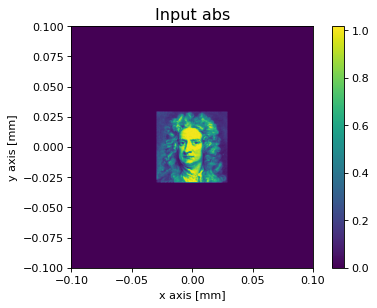

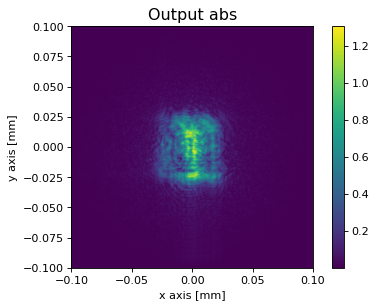

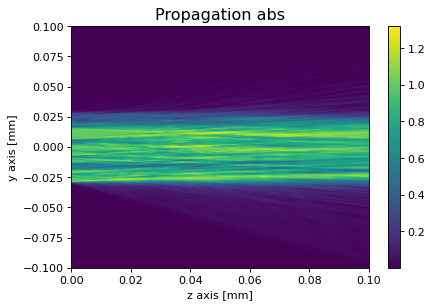

In [10]:
fig_dpi = 80
plt.figure(dpi = fig_dpi)
plt.imshow(np.abs(u), extent=[-Lx_/2*1e3,Lx_/2*1e3,-Ly_/2*1e3,Ly_/2*1e3])
plt.colorbar()
plt.xlabel('x axis [mm]')
plt.ylabel('y axis [mm]')
plt.title('Input abs', fontsize='x-large')
plt.show()

plt.figure(dpi = fig_dpi)
plt.imshow(np.abs(output), extent=[-Lx_/2*1e3,Lx_/2*1e3,-Ly_/2*1e3,Ly_/2*1e3])
plt.colorbar()
plt.xlabel('x axis [mm]')
plt.ylabel('y axis [mm]')
plt.title('Output abs', fontsize='x-large')
plt.show()

plt.figure(dpi = fig_dpi)
plt.imshow(np.squeeze(np.abs(fields[:,round(Ny/2),:])), aspect='auto', extent=[0,Lz_*1e3,-Ly_/2*1e3,Ly_/2*1e3])
plt.colorbar()
plt.xlabel('z axis [mm]')
plt.ylabel('y axis [mm]')
plt.title('Propagation abs', fontsize='x-large')
plt.show()
